In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

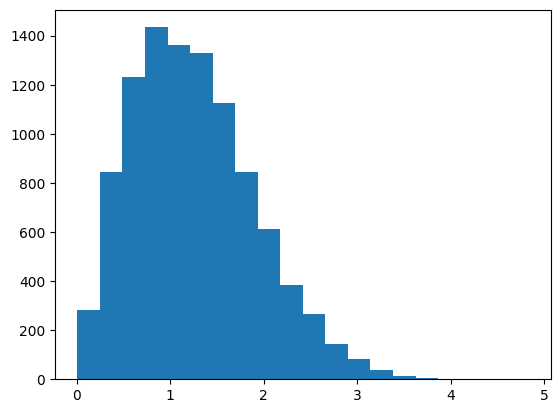

In [7]:
fig, ax = plt.subplots()
ax.hist(np.random.rayleigh(size=10000), bins=20)
plt.show()

In [41]:
Q_factor = 1e3
freq = 1e3
sample_freq = 1e4
sample_duration = 1e2

def get_theta():
    theta_amps = np.random.rayleigh(size=int(sample_duration / (freq / Q_factor)))
    start_time = 0
    thetas = np.array([])
    coherence_time = freq / Q_factor
    ts = np.arange(0, coherence_time, 1/sample_freq)
    for amp in theta_amps:
        thetas = np.append(thetas, amp * np.sin(2 * np.pi * freq * (1 + np.random.normal(scale=1) / Q_factor) * (ts + start_time) + np.random.uniform(0, 2*np.pi)))
        start_time += coherence_time
    return thetas

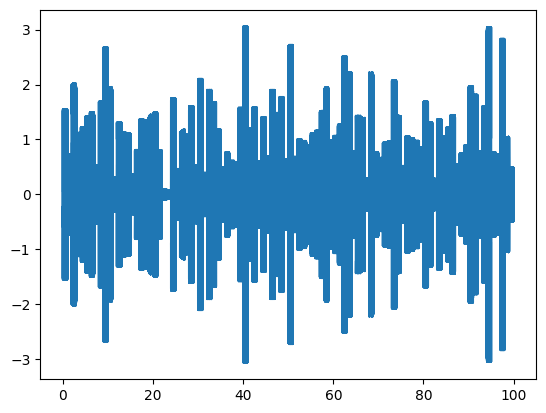

In [42]:
thetas = get_theta()
ts = np.arange(len(thetas)) / sample_freq

fig, ax = plt.subplots()
ax.plot(ts, thetas)
plt.show()

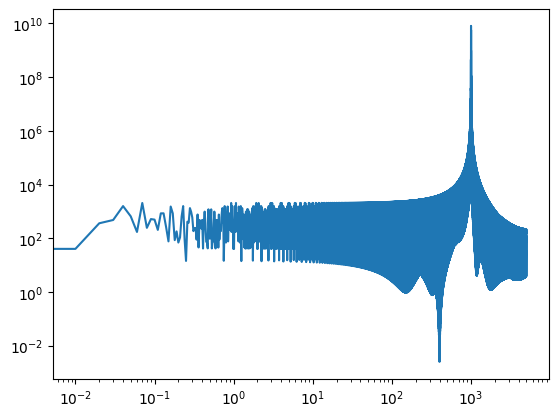

In [43]:
power = np.abs(np.fft.rfft(thetas)) ** 2
fs = np.fft.rfftfreq(len(thetas), 1 / sample_freq)
fig, ax = plt.subplots()
ax.plot(fs, power)
ax.set_yscale("log")
ax.set_xscale("log")
plt.show()

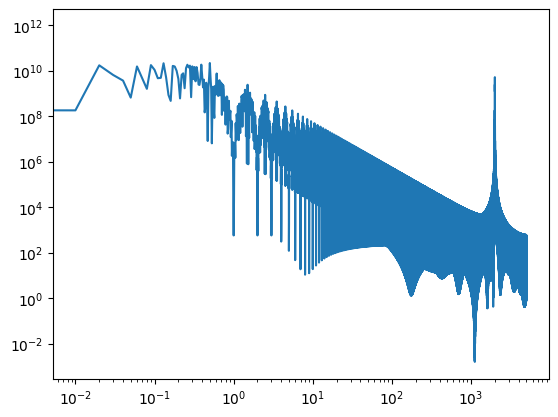

In [44]:
power_theta_sq = np.abs(np.fft.rfft(thetas**2)) ** 2
fs = np.fft.rfftfreq(len(thetas), 1 / sample_freq)
fig, ax = plt.subplots()
ax.plot(fs, power_theta_sq)
ax.set_yscale("log")
ax.set_xscale("log")
plt.show()

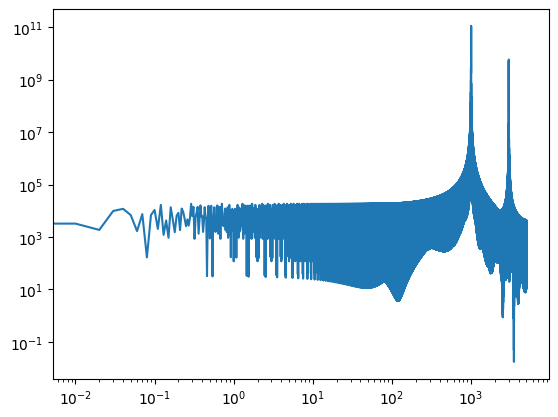

In [58]:
power_theta_cube = np.abs(np.fft.rfft(thetas**3)) ** 2
fs = np.fft.rfftfreq(len(thetas), 1 / sample_freq)
fig, ax = plt.subplots()
ax.plot(fs, power_theta_cube)
ax.set_yscale("log")
ax.set_xscale("log")
plt.show()

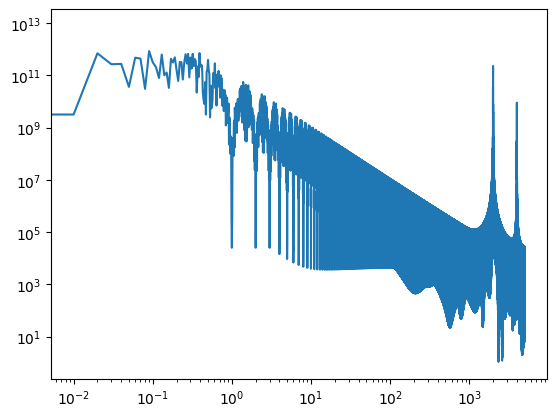

In [59]:
power_theta_4 = np.abs(np.fft.rfft(thetas**4)) ** 2
fs = np.fft.rfftfreq(len(thetas), 1 / sample_freq)
fig, ax = plt.subplots()
ax.plot(fs, power_theta_4)
ax.set_yscale("log")
ax.set_xscale("log")
plt.show()

In [49]:
def average(array, N):
    N = int(N)
    return np.mean(array[:(len(array)//N)*N].reshape(-1,N), axis=1)

In [51]:
average_N = Q_factor

thetas_downsample = average(thetas, average_N)
thetas_sq_downsample = average(thetas**2, average_N)
ts_downsample = average(ts, average_N)
thetas_downsample_sq = thetas_downsample ** 2

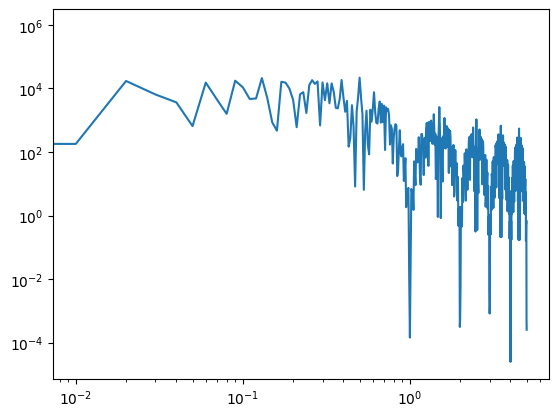

In [54]:
power_theta_sq_downsample = np.abs(np.fft.rfft(thetas_sq_downsample)) ** 2
fs_downsample = np.fft.rfftfreq(len(thetas_sq_downsample), ts_downsample[1] - ts_downsample[0])
fig, ax = plt.subplots()
ax.plot(fs_downsample, power_theta_sq_downsample)
ax.set_yscale("log")
ax.set_xscale("log")
plt.show()

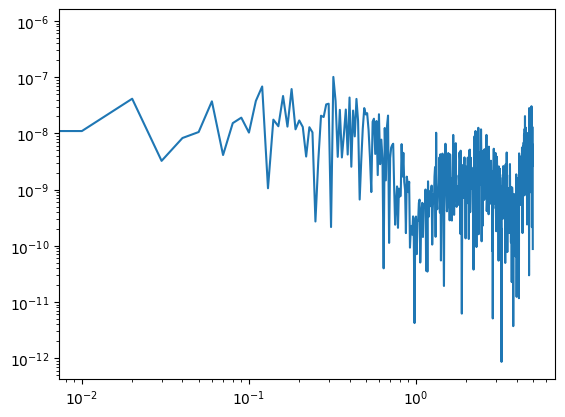

In [55]:
power_theta_downsample_sq = np.abs(np.fft.rfft(thetas_downsample_sq)) ** 2
fs_downsample = np.fft.rfftfreq(len(thetas_downsample_sq), ts_downsample[1] - ts_downsample[0])
fig, ax = plt.subplots()
ax.plot(fs_downsample, power_theta_downsample_sq)
ax.set_yscale("log")
ax.set_xscale("log")
plt.show()

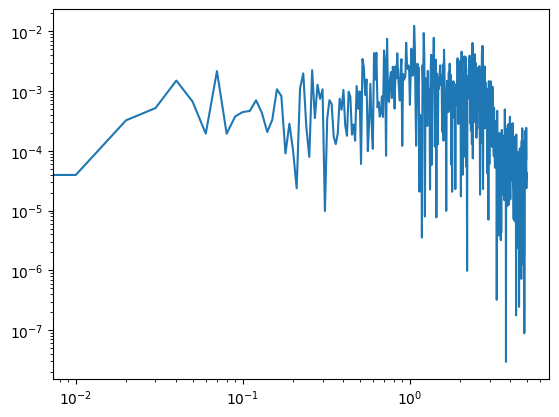

In [57]:
power_theta_downsample = np.abs(np.fft.rfft(thetas_downsample)) ** 2
fs_downsample = np.fft.rfftfreq(len(ts_downsample), ts_downsample[1] - ts_downsample[0])
fig, ax = plt.subplots()
ax.plot(fs_downsample, power_theta_downsample)
ax.set_yscale("log")
ax.set_xscale("log")
plt.show()